<a href="https://githubtocolab.com/alsinmr/WindeschleubaNMRSchool/blob/main/JupyterExercises/Sol2/sol3_one_spin_CSA_pulse_acquire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-spin pulse acquire with chemical shift anisotropy

### 1) Imports, functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import expm

def erot(alpha,beta,gamma):
    sa = np.sin(alpha)
    ca = np.cos(alpha)
    sb = np.sin(beta)
    cb = np.cos(beta)
    sg = np.sin(gamma)
    cg = np.cos(gamma)

    # Return passive rotation matrix
    return np.array([[cg*cb*ca-sg*sa,   cg*cb*sa+sg*ca,  -cg*sb],
                     [-sg*cb*ca-cg*sa,  -sg*cb*sa+cg*ca,   sg*sb],
                     [sb*ca,            sb*sa,            cb]])

In [ ]:
#This cell downloads the powder averages if running in Colab. Otherwise, you should have them already
import sys
if 'google.colab' in sys.modules:
    %git clone https://github.com/alsinmr/WindeschleubaNMRSchool

### 2) Build spin operator matrices

In [2]:
Ix = 1/2*np.array([[0,1],[1,0]])
Iy = 1/2*np.array([[0,-1j],[1j,0]])
Iz = 1/2*np.array([[1,0],[0,-1]])
E  = np.eye(2)

### 3) Set simulation parameters

In [3]:
rho0 = Ix #Starting density operator
detOp = Ix + 1j*Iy #Detection operator

dt = 10e-6  #Sampling step, "dwell time"
nPoints = 1024  #Length of acquisition
t = np.arange(1024)*dt #time vector

### 4) Give powder parameters
CSA tensor, in kHz

In [4]:
shift_xx = -10e3
shift_yy = -5e3
shift_zz = 10e3

CSA_PAS = np.diag([shift_xx,shift_yy,shift_zz]);

# load powder angles and corresponding weights
# load leb_2ang_rank_11 % loads angles and corresponding weights
#pwd=loadmat('leb_2ang_rank_11.mat')
pwd=loadmat('leb_2ang_rank_101.mat')
#pwd=loadmat('rep_2ang_6400pts_sph.mat')
alphas,betas,gammas,weights=[pwd[k].squeeze() for k in ['alphas','betas','gammas','weights']]

### 5) Loop over powder angles

In [5]:
sig = np.zeros(nPoints,dtype=complex) #Pre-allocation of signal vector

for a,b,g,w in zip(alphas,betas,gammas,weights):
    # rotate CSA tensor
    R = erot(a,b,g)
    CSA_LAB = R@CSA_PAS@R.T;
    
       
    # set Hamiltonian parameters and build the matrix
    offset = CSA_LAB[2,2]; 
    H0 = offset*Iz;
    
    # build propagator of free evolution, and acquire
    U0 = expm(-1j*2*np.pi*H0*dt)
    #reset density matrix
    rho = rho0;
    for it in range(nPoints):
        sig[it]+=w*np.trace(detOp@rho) # detect
        rho = U0@rho@U0.T.conj() # propagation

### 6) Plot real and imaginary part

(0.0, 10.23)

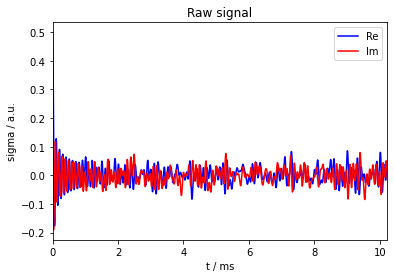

In [6]:
ax=plt.figure().add_subplot(111)
ax.set_title('Raw signal')
ax.plot(t*1e3,sig.real,color='blue')
ax.plot(t*1e3,sig.imag,color='red')
ax.set_xlabel('t / ms')
ax.set_ylabel('sigma / a.u.')
ax.legend(['Re','Im'])
ax.set_xlim([0,t[-1]*1e3])

### 7) Apodize with window function and plot

(0.0, 10.23)

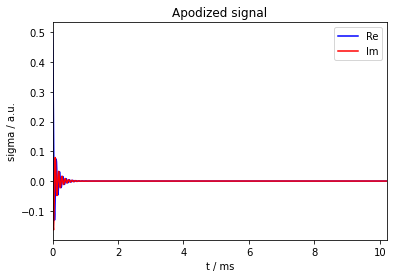

In [7]:
twin = 0.2e-3  #Apodization parameter
win = np.exp(-t/twin)

sig_apo = sig*win #Apply window to signal

ax=plt.figure().add_subplot(111)
ax.set_title('Apodized signal')
ax.plot(t*1e3,sig_apo.real,color='blue')
ax.plot(t*1e3,sig_apo.imag,color='red')
ax.set_xlabel('t / ms')
ax.set_ylabel('sigma / a.u.')
ax.legend(['Re','Im'])
ax.set_xlim([0,t[-1]*1e3])

### 8) Fourier transform with Zero-filling, construction of frequency vector

(-49.99999999999999, 49.95117187499999)

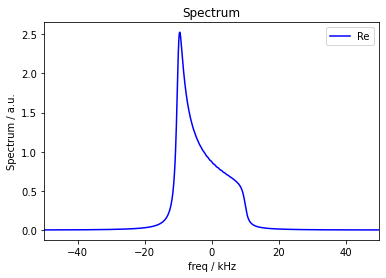

In [8]:
#fft with zerofilling two twice the original points
sig_apo[0]/=2
spec = np.fft.fftshift(np.fft.fft(sig_apo,2*nPoints));

#frequency vector
N=len(spec)
nyqFreq = 1/(2*dt)
unitAxis = 2/N * (np.arange(N)-np.fix(N/2))
freq = nyqFreq * unitAxis;

ax=plt.figure().add_subplot(111)
ax.set_title('Spectrum')
ax.plot(freq/1e3,spec.real,color='blue')
#ax.plot(freq/1e3,spec.imag,color='red')
#ax.plot(freq/1e3,np.abs(spec),color='black',linestyle='--')
ax.set_xlabel('freq / kHz')
ax.set_ylabel('Spectrum / a.u.')
ax.legend(['Re','Im','Abs'])
ax.set_xlim([freq[0]/1e3,freq[-1]/1e3])